In [1]:
import numpy as np
import matplotlib.pyplot as plt

# local module
import sys
sys.path.append('../src')
from enkf import estimate
from simulation import simulate, generate_observations

# Example 1: Lorenz system

## Define model and generate data

In [2]:
## Define forward model
# Initial conditions
x_true = np.random.rand(3)

# Define the differential equations of the Lorenz system
dt = 0.02
def lorenz_system(state, dt):
    
    # Define the Lorenz system's parameters
    sigma = 10
    rho = 28
    beta = 8/3   
    
    x, y, z = state
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return np.array([dx_dt, dy_dt, dz_dt])

# Euler's method for numerical integration
def f_lorenz(x): return x + lorenz_system(x, dt) * dt

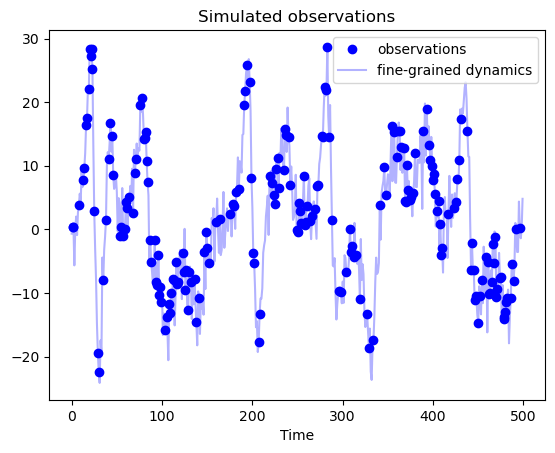

In [3]:
## Generate data

# Simulate true latent trajectory
sol = simulate( f_lorenz, x_true, 500)
sol = np.array(sol)

## Simulate noisy data
# Observation operator (as a matrix)
H = np.array([[1, 0.2, 0]])
# Observational noise covariance
Σy = np.diag([ np.std(sol)/2 ])

# Generate and visualize data data
data_ = generate_observations(sol, H, Σy)
## Irregular sampling:
# # Option 1. Assume the system is observed every m timesteps
# sampling_rate = 5 # timesteps/observation
# observation_timestamps = range(0, len(data_), sampling_rate)
# Option 2. Choose random time indexes as observation points (irregular sampling)
observation_timestamps = np.random.choice( range(len(data_)), size=200, replace=None )
observation_timestamps = list( np.sort( observation_timestamps ) )
data = data_[observation_timestamps]

# Visualize data
plt.plot( observation_timestamps, data, color='blue', marker='o', lw=0, label='observations' )
plt.plot( data_, alpha=0.3, color='blue', label='fine-grained dynamics' )

plt.legend()
plt.title("Simulated observations")
plt.xlabel("Time");

## Initialize filter parameters

In [4]:
# Generate particles.
# Here, particles are sampled from a Gaussian ball centered at μx with covariance Σx.
def sample_particles(n_particles, μx, Σx):    
    return np.random.multivariate_normal( μx, Σx, size=n_particles )

μx_particles = np.array([0.6,-1, 0.1])
Σx_particles = np.identity( len(μx_particles) ) * 2.8
n_particles = 15
# Sample particles
particles = sample_particles(n_particles, μx_particles, Σx_particles)

## Define the filter's model and how to observe it
# Forward model (update function)
def f(x): return f_lorenz(x)    
# Observation operator (as a matrix)
H_hk = np.copy(H)
# Observational noise covariance
Σy_kf = np.copy(Σy)

### Run filter and visualize results

In [5]:
# Run the ensemble Kalman filter
%time y_hat, x_hat = estimate(f, data, particles, H, Σy, timestamps=observation_timestamps)

CPU times: user 58.3 ms, sys: 2.16 ms, total: 60.5 ms
Wall time: 59.6 ms


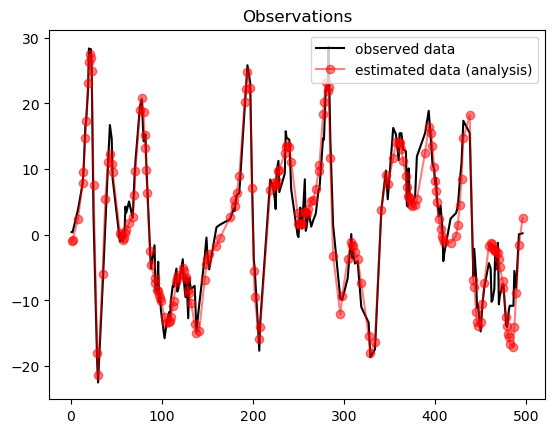

In [6]:
plt.plot(observation_timestamps, data, color='black', label="observed data")
plt.plot(observation_timestamps, y_hat, marker='o', color='red', alpha=0.5, label="estimated data (analysis)" )

plt.title("Observations")
plt.legend()

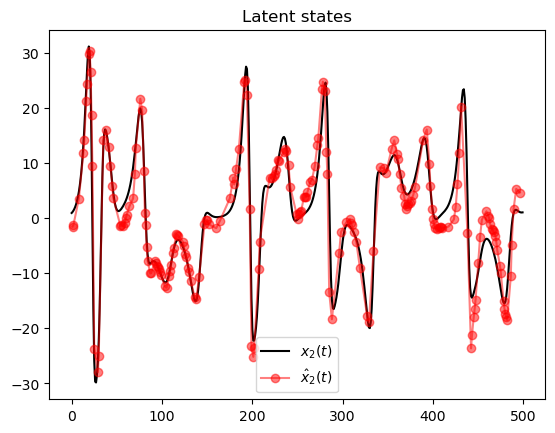

In [7]:
# Plot unobserved coordenate of system
plt.plot(sol[:,1], color='black', label="$x_2(t)$")
plt.plot(observation_timestamps, x_hat[:,1], marker='o', color='red', alpha=0.5, label="$\hat{x}_2(t)$" )

plt.title("Latent states")
plt.legend()

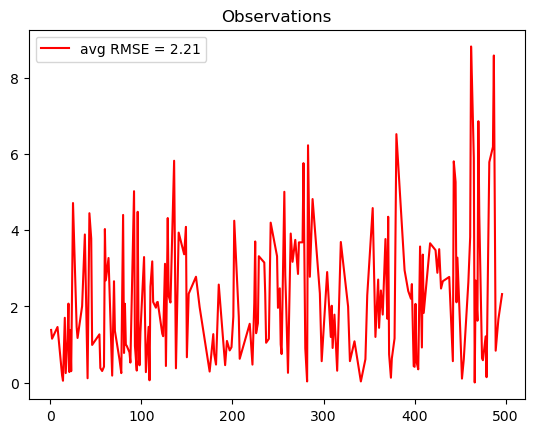

In [8]:
## Errors observations
def rmse(x,x_hat): return np.sqrt( np.mean( np.abs( x - x_hat )**2, axis=1 ) )

error = rmse(data, y_hat)
plt.plot(observation_timestamps, error, alpha=1, color='red', label=f"avg RMSE = {round( np.mean(error), 2 )}")

plt.title("Observations")
plt.legend()

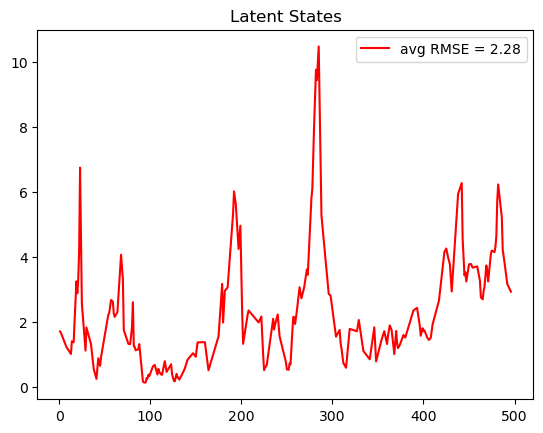

In [9]:
## Errors latent states
error = rmse(sol[observation_timestamps,:], x_hat)
plt.plot(observation_timestamps, error, alpha=1, color='red', label=f"avg RMSE = {round( np.mean(error), 2 )}")

plt.title("Latent States")
plt.legend()

## Example 2: Linear system with noise

### Define model and generate data

In [10]:
## Define forward model
# Initial conditions
x_true = np.array([2.1, 1.5])

# Transition matrix
F = np.array([[0.3, -1], [1, -0.5]]) # Downward spiral
# State covariance
Σx = np.identity( len(x_true) ) * 0.5
# Forward model (linear with additive Gaussian noise)
def f_linear(x): return np.dot(F, x) + np.random.multivariate_normal( np.zeros(len(Σx)), Σx )

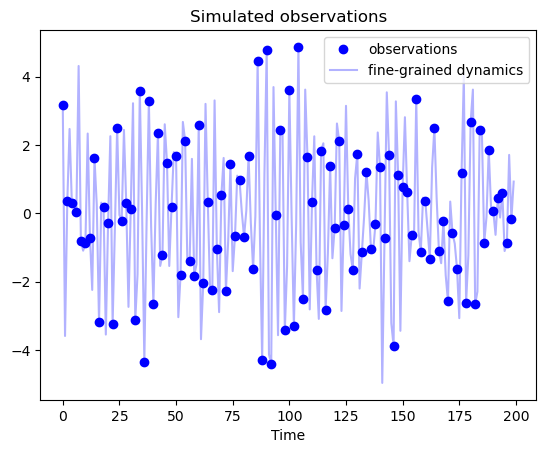

In [11]:
## Generate data

# Simulate true latent trajectory
sol = simulate( f_linear, x_true, 200)
sol = np.array(sol)
## Simulate noisy data
# Observation operator (as a matrix)
H = np.array([[1, 0]])
# Observational noise covariance
Σy = np.diag([0.5])

# Generate and visualize data data
data_ = generate_observations(sol, H, Σy)
## Irregular sampling:
#  Assume the system is observed every m timesteps
sampling_rate = 2 # timesteps/observation
observation_timestamps = range(0, len(data_), sampling_rate)
data = data_[observation_timestamps]

# Visualize data
plt.plot( observation_timestamps, data, color='blue', marker='o', lw=0, label='observations' )
plt.plot( data_, alpha=0.3, color='blue', label='fine-grained dynamics' )

plt.legend()
plt.title("Simulated observations")
plt.xlabel("Time");

### Initialize filter parameters

In [12]:
# Generate particles.
# Here, particles are sampled from a Gaussian ball centered at μx with covariance Σx.
def sample_particles(n_particles, μx, Σx):    
    return np.random.multivariate_normal( μx, Σx, size=n_particles )

μx_particles = np.array([5,-1])
Σx_particles = np.identity( len(μx_particles) ) * 1.5
n_particles = 5
# Sample particles
particles = sample_particles(n_particles, μx_particles, Σx_particles)

## Define the filter's model and how to observe it
## Forward model (update function)
# Transition matrix
F_kf = np.copy(F)
# Model state covariance
Σx_kf = np.copy(Σx)
# Forward model step function. Here, Fx + ϵ; ϵ ~ N(0, Σx)
def f(x): return np.dot(F_kf, x) + np.random.multivariate_normal( np.zeros(len(Σx_kf)), Σx_kf )
    
## Observation operator (as a matrix)
H_hk = np.copy(H)
# Observational noise covariance
Σy_kf = np.copy(Σy)

### Run filter and visualize results

In [13]:
# Run the ensemble Kalman filter
%time y_hat, x_hat = estimate(f, data, particles, H, Σy, timestamps=observation_timestamps)

CPU times: user 63.8 ms, sys: 4.56 ms, total: 68.4 ms
Wall time: 67.3 ms


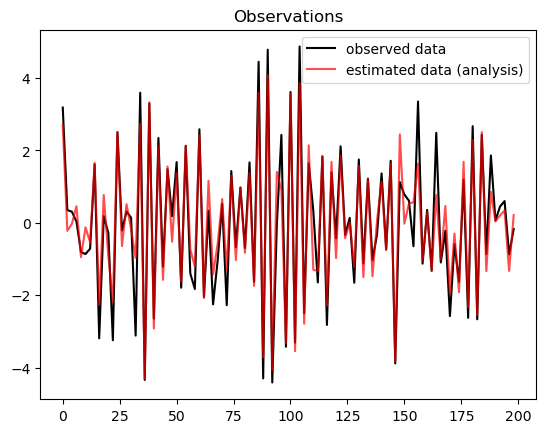

In [14]:
plt.plot(observation_timestamps, data, color='black', label="observed data")
plt.plot(observation_timestamps, y_hat, color='red', alpha=0.7, label="estimated data (analysis)" )

plt.title("Observations")
plt.legend()


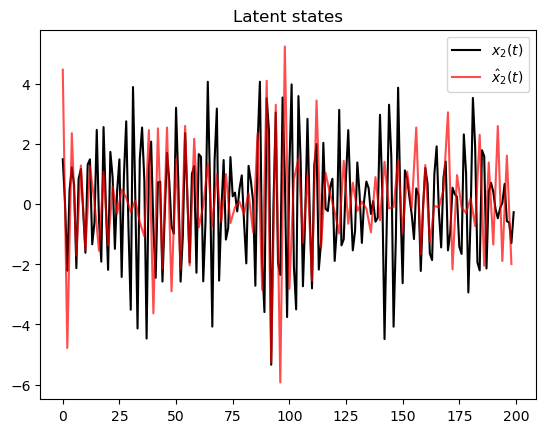

In [15]:
# Plot unobserved coordenate of system
plt.plot(sol[:,1], color='black', label="$x_2(t)$")
plt.plot(observation_timestamps, x_hat[:,1], color='red', alpha=0.7, label="$\hat{x}_2(t)$" )

plt.title("Latent states")
plt.legend()

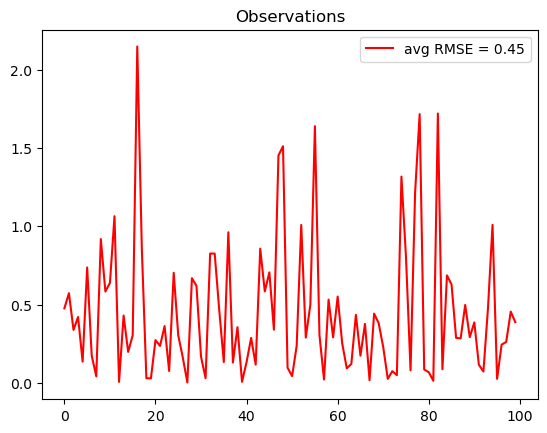

In [16]:
## Errors observations
def rmse(x,x_hat): return np.sqrt( np.mean( np.abs( x - x_hat )**2, axis=1 ) )

error = rmse(data, y_hat)
plt.plot(error, alpha=1, color='red', label=f"avg RMSE = {round( np.mean(error), 2 )}")

plt.title("Observations")
plt.legend()

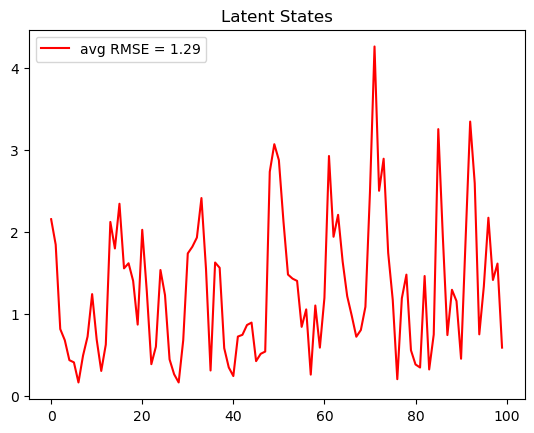

In [17]:
## Errors latent states
def rmse(x,x_hat): return np.sqrt( np.mean( np.abs( x - x_hat )**2, axis=1 ) )

error = rmse(sol[observation_timestamps,:], x_hat)
plt.plot(error, alpha=1, color='red', label=f"avg RMSE = {round( np.mean(error), 2 )}")

plt.title("Latent States")
plt.legend()